In [5]:
import torch
import torchvision
import datasets, networks, sampling, evaluation
import matplotlib.pyplot as plt
from torch import nn, optim

In [6]:
# HYPERPARAMETERS
num_epochs = 12

# TODO Select a optimizer. [ 'adam', 'adamw', 'rmsprop' ]
optimizer_option = 'adam'

# TODO Select a lr scheduler. [ 'step', 'cosine', 'exponential']
lr_scheduler_option = 'step'

# TODO Select a batch size.
batch_size = 64

# TODO Select a learning rate.
lr= 0.001

num_units=2300
num_layer=4

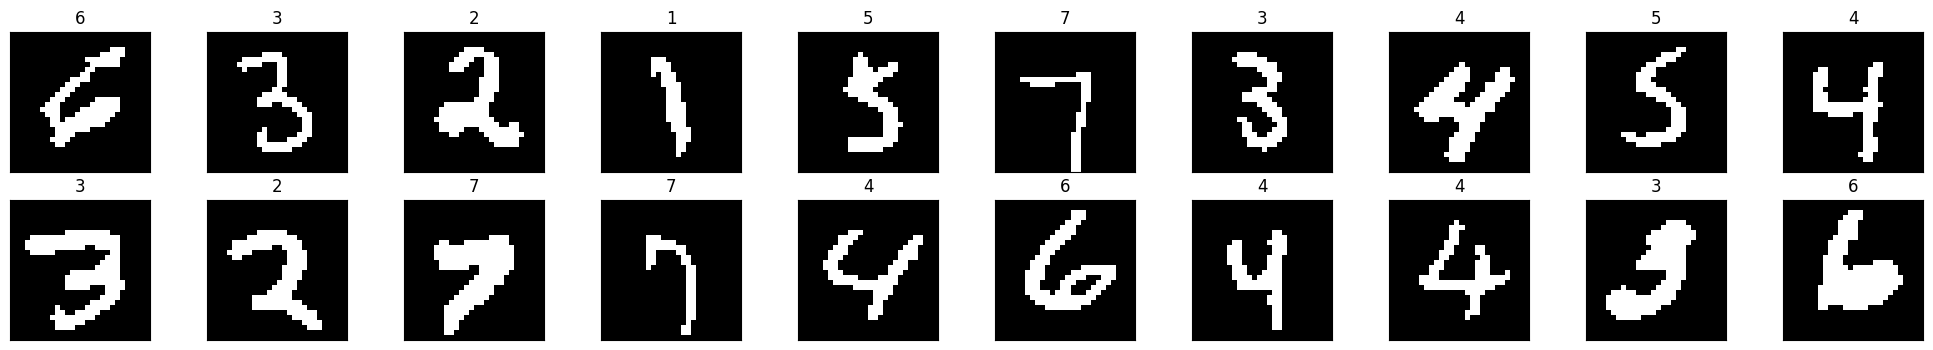

In [7]:
# Create Dataset/Data Loaders and visualize Dataset
Ds = datasets.Dataset('mnist', batch_size=batch_size)
training_data = Ds.get_train_data_loader()
test_data = Ds.get_test_data_loader()

Ds.visualize_dataset(training_data)


ordering=range(1,785) 

Using device: cuda:0
Epoch:   1/ 12, Batch     1, Loss: 0.6932
Epoch:   1/ 12, Batch   101, Loss: 0.3412
Epoch:   1/ 12, Batch   201, Loss: 0.2483
Epoch:   1/ 12, Batch   301, Loss: 0.2240
Epoch:   1/ 12, Batch   401, Loss: 0.2098
Epoch:   1/ 12, Batch   501, Loss: 0.1964
Epoch:   1/ 12, Batch   601, Loss: 0.1860
Epoch:   1/ 12, Batch   701, Loss: 0.1744
Epoch:   1/ 12, Batch   801, Loss: 0.1665
Epoch:   1/ 12, Batch   901, Loss: 0.1610
-----------------------------------------
Epoch:   1 took 4.31s
Epoch:   1, Test Loss: 0.1557
-----------------------------------------


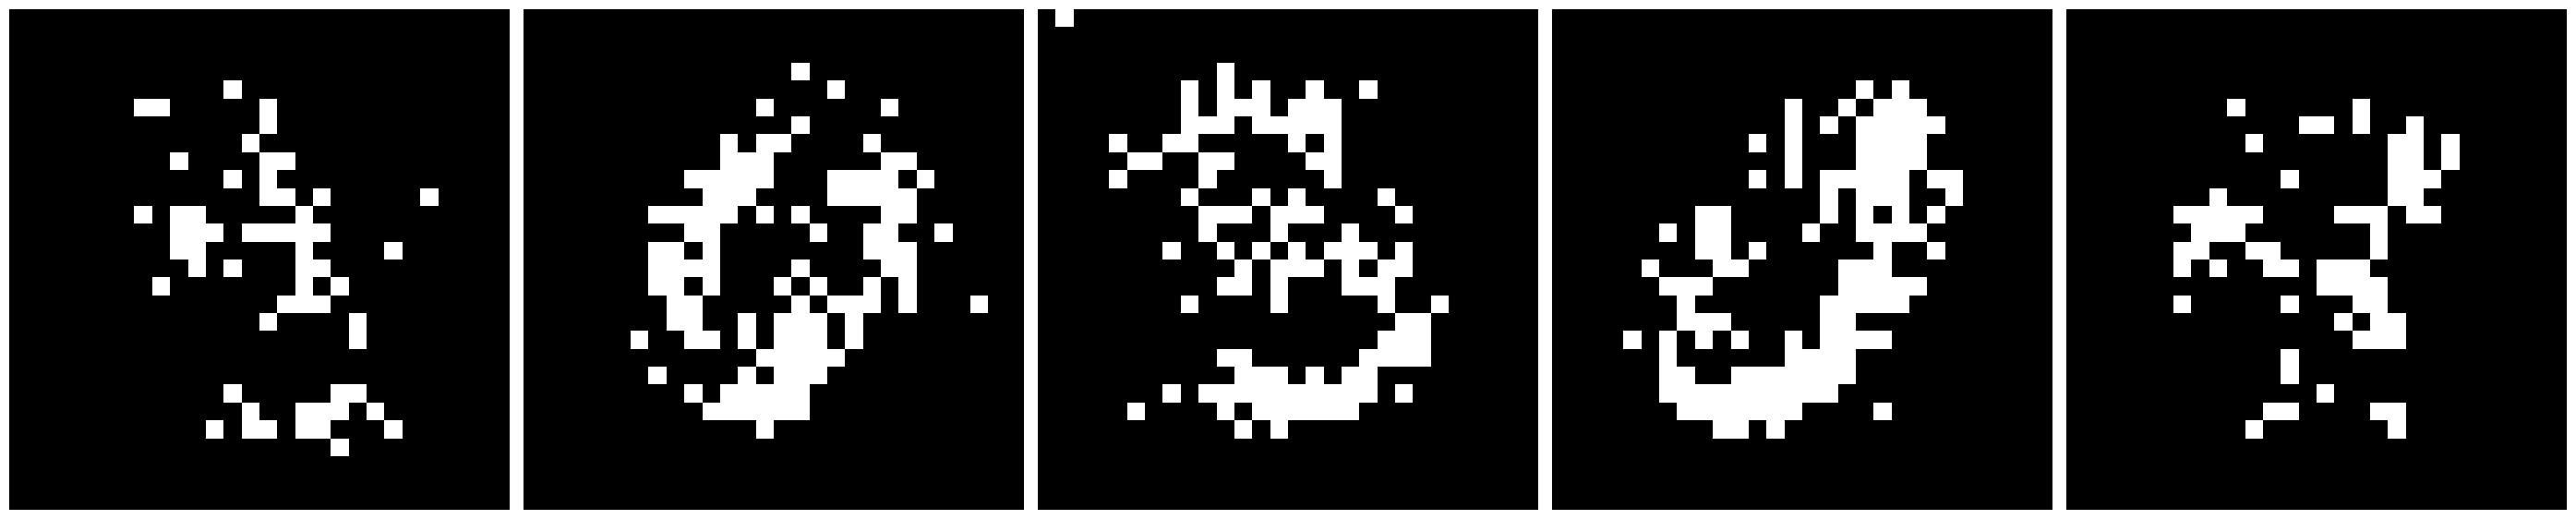

Epoch:   2/ 12, Batch     1, Loss: 0.1629
Epoch:   2/ 12, Batch   101, Loss: 0.1547
Epoch:   2/ 12, Batch   201, Loss: 0.1516
Epoch:   2/ 12, Batch   301, Loss: 0.1482
Epoch:   2/ 12, Batch   401, Loss: 0.1461
Epoch:   2/ 12, Batch   501, Loss: 0.1425
Epoch:   2/ 12, Batch   601, Loss: 0.1397
Epoch:   2/ 12, Batch   701, Loss: 0.1390
Epoch:   2/ 12, Batch   801, Loss: 0.1354
Epoch:   2/ 12, Batch   901, Loss: 0.1336
-----------------------------------------
Epoch:   2 took 4.03s
Epoch:   2, Test Loss: 0.1306
-----------------------------------------


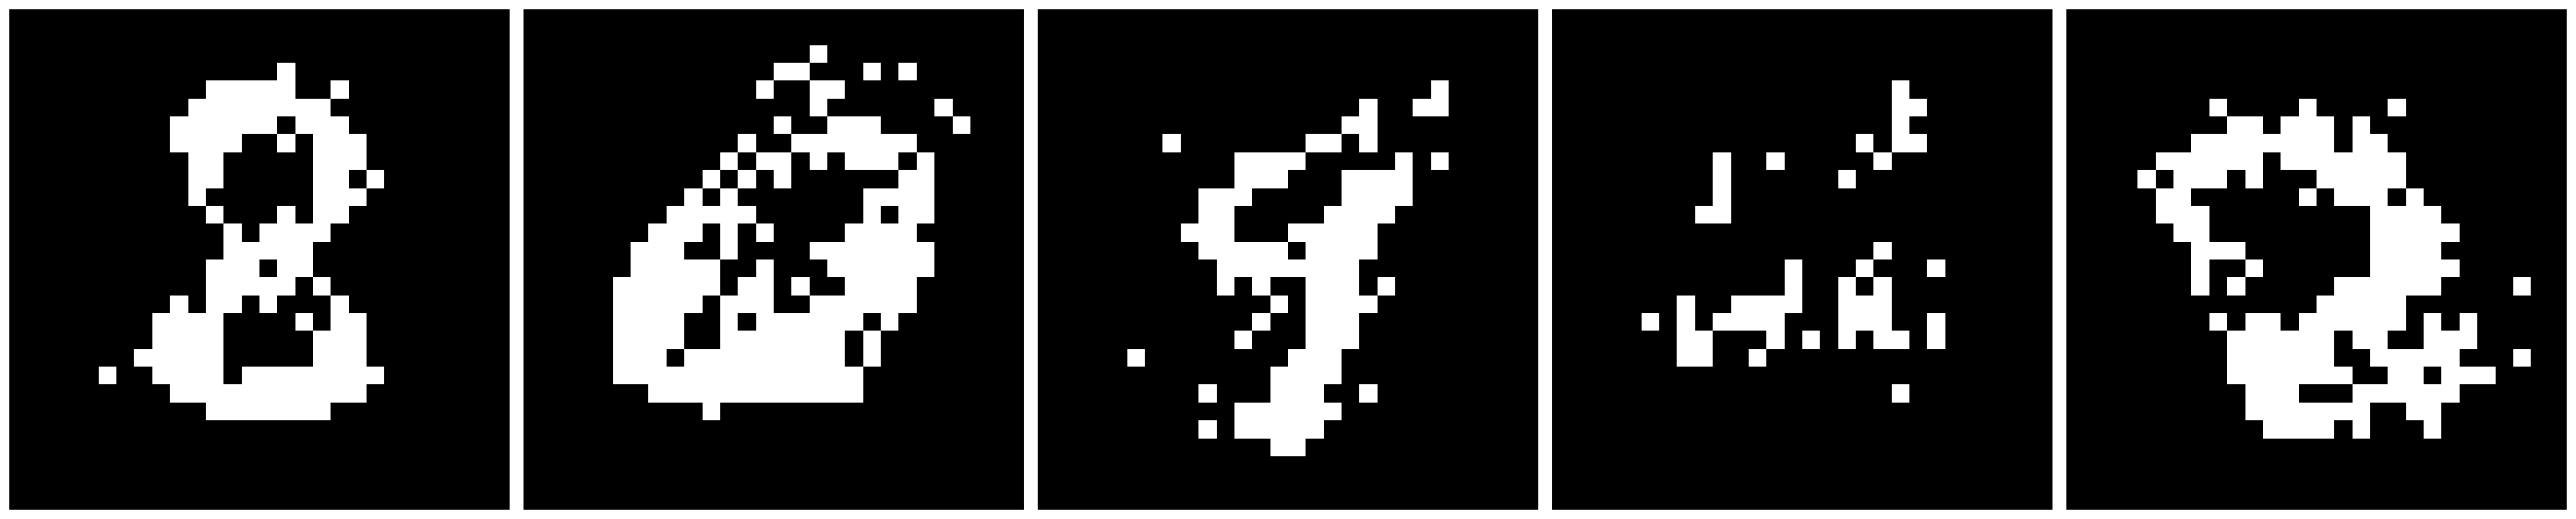

Epoch:   3/ 12, Batch     1, Loss: 0.1217
Epoch:   3/ 12, Batch   101, Loss: 0.1299
Epoch:   3/ 12, Batch   201, Loss: 0.1262
Epoch:   3/ 12, Batch   301, Loss: 0.1258
Epoch:   3/ 12, Batch   401, Loss: 0.1265
Epoch:   3/ 12, Batch   501, Loss: 0.1241
Epoch:   3/ 12, Batch   601, Loss: 0.1225
Epoch:   3/ 12, Batch   701, Loss: 0.1226
Epoch:   3/ 12, Batch   801, Loss: 0.1211
Epoch:   3/ 12, Batch   901, Loss: 0.1205
-----------------------------------------
Epoch:   3 took 4.06s
Epoch:   3, Test Loss: 0.1199
-----------------------------------------


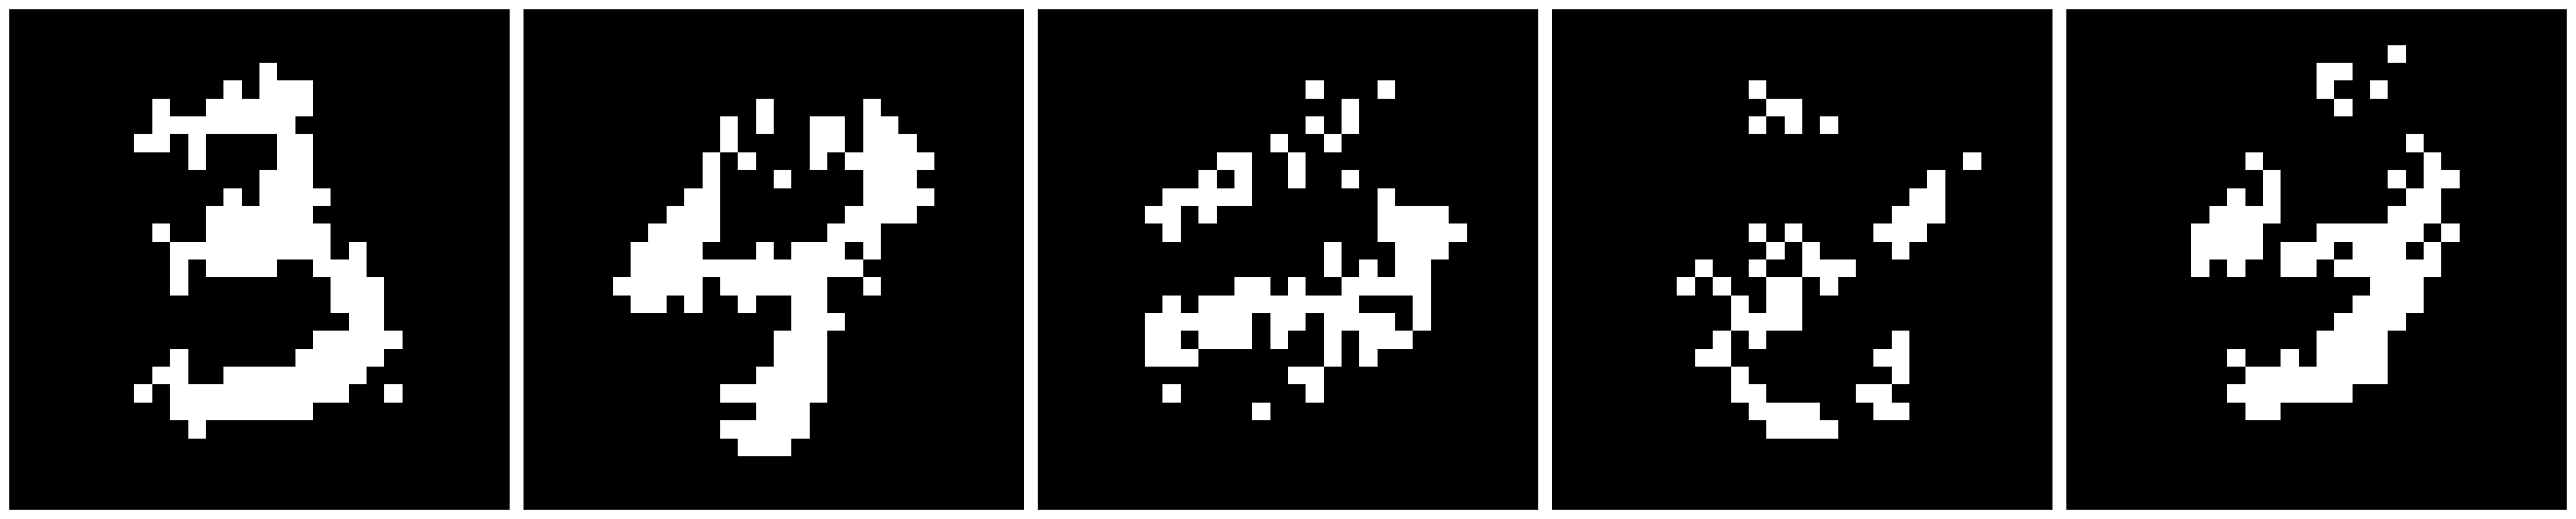

Epoch:   4/ 12, Batch     1, Loss: 0.1112
Epoch:   4/ 12, Batch   101, Loss: 0.1180
Epoch:   4/ 12, Batch   201, Loss: 0.1172
Epoch:   4/ 12, Batch   301, Loss: 0.1174
Epoch:   4/ 12, Batch   401, Loss: 0.1165
Epoch:   4/ 12, Batch   501, Loss: 0.1167
Epoch:   4/ 12, Batch   601, Loss: 0.1160
Epoch:   4/ 12, Batch   701, Loss: 0.1143
Epoch:   4/ 12, Batch   801, Loss: 0.1151
Epoch:   4/ 12, Batch   901, Loss: 0.1146
-----------------------------------------
Epoch:   4 took 4.01s
Epoch:   4, Test Loss: 0.1154
-----------------------------------------


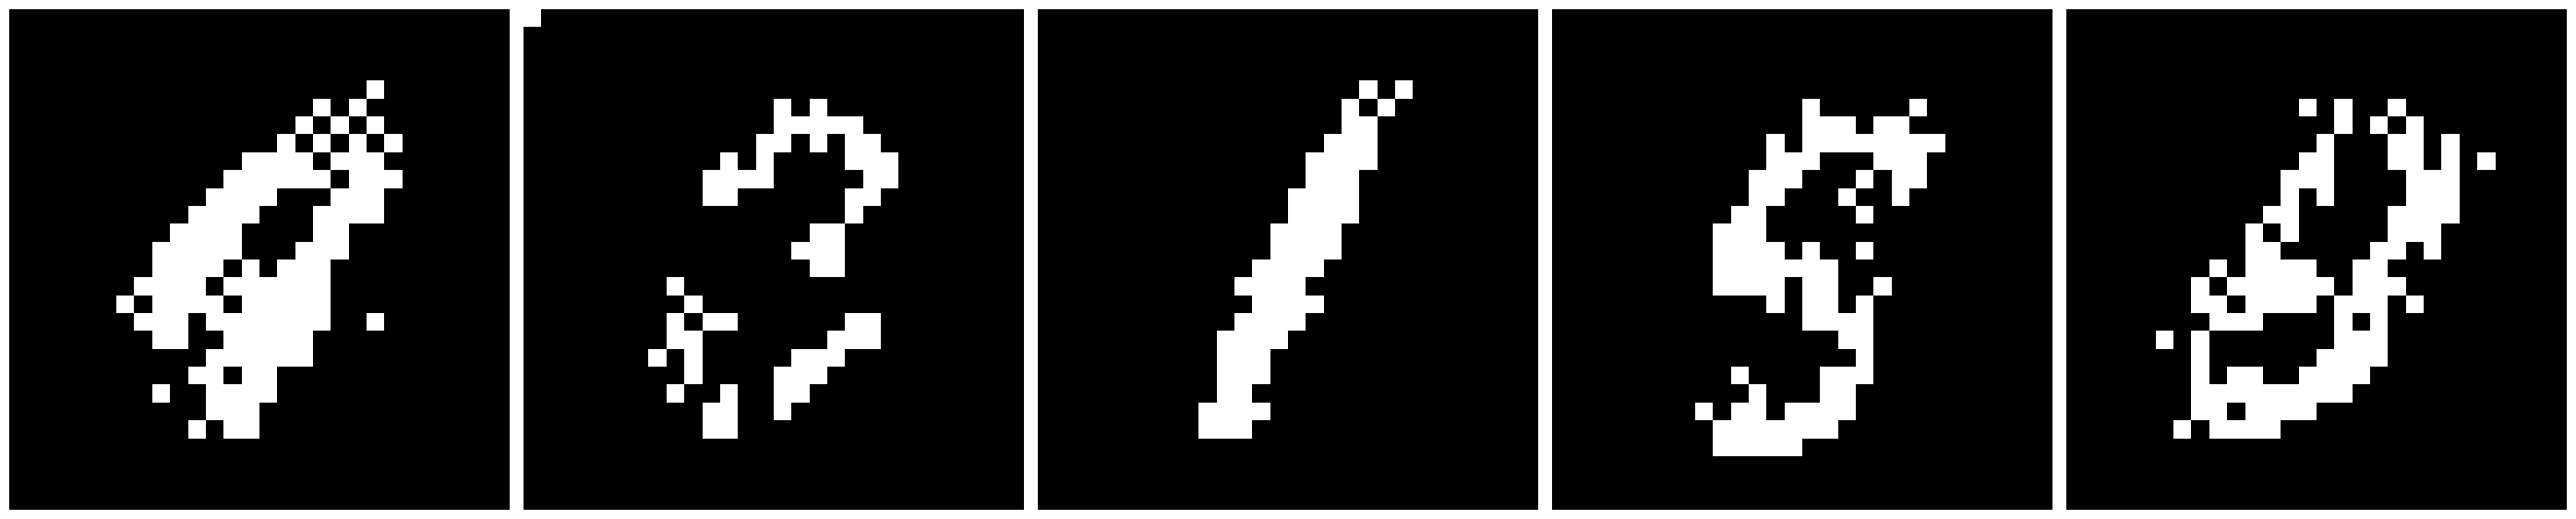

Epoch:   5/ 12, Batch     1, Loss: 0.1198
Epoch:   5/ 12, Batch   101, Loss: 0.1111
Epoch:   5/ 12, Batch   201, Loss: 0.1116
Epoch:   5/ 12, Batch   301, Loss: 0.1109
Epoch:   5/ 12, Batch   401, Loss: 0.1116
Epoch:   5/ 12, Batch   501, Loss: 0.1102
Epoch:   5/ 12, Batch   601, Loss: 0.1117
Epoch:   5/ 12, Batch   701, Loss: 0.1114
Epoch:   5/ 12, Batch   801, Loss: 0.1109
Epoch:   5/ 12, Batch   901, Loss: 0.1098
-----------------------------------------
Epoch:   5 took 4.02s
Epoch:   5, Test Loss: 0.1124
-----------------------------------------


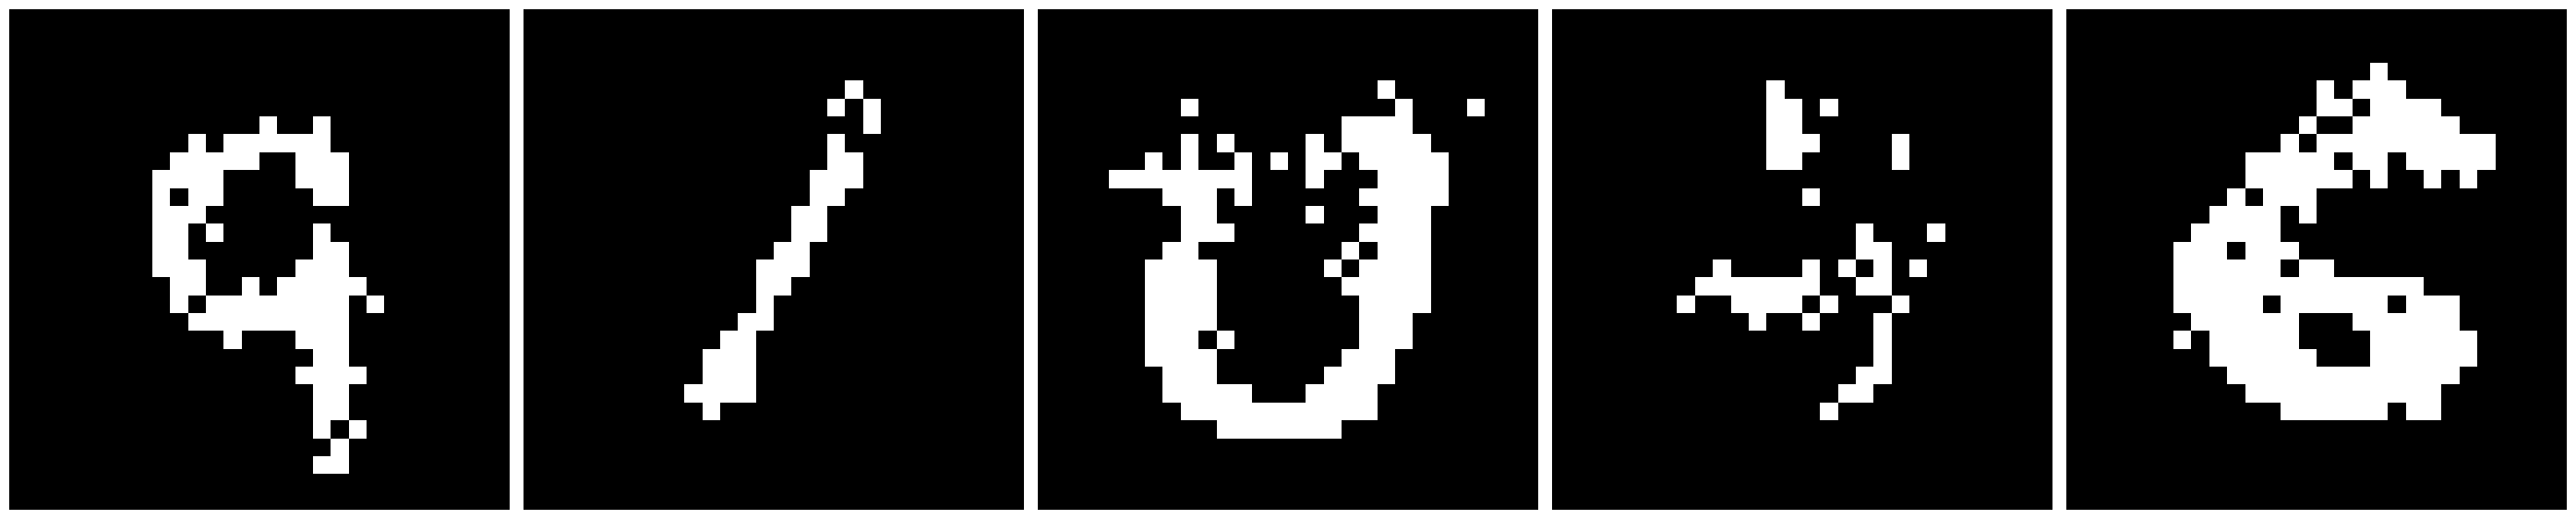

Epoch:   6/ 12, Batch     1, Loss: 0.1015
Epoch:   6/ 12, Batch   101, Loss: 0.1077
Epoch:   6/ 12, Batch   201, Loss: 0.1071
Epoch:   6/ 12, Batch   301, Loss: 0.1079
Epoch:   6/ 12, Batch   401, Loss: 0.1075
Epoch:   6/ 12, Batch   501, Loss: 0.1080
Epoch:   6/ 12, Batch   601, Loss: 0.1084
Epoch:   6/ 12, Batch   701, Loss: 0.1078
Epoch:   6/ 12, Batch   801, Loss: 0.1079
Epoch:   6/ 12, Batch   901, Loss: 0.1077
-----------------------------------------
Epoch:   6 took 4.01s
Epoch:   6, Test Loss: 0.1101
-----------------------------------------


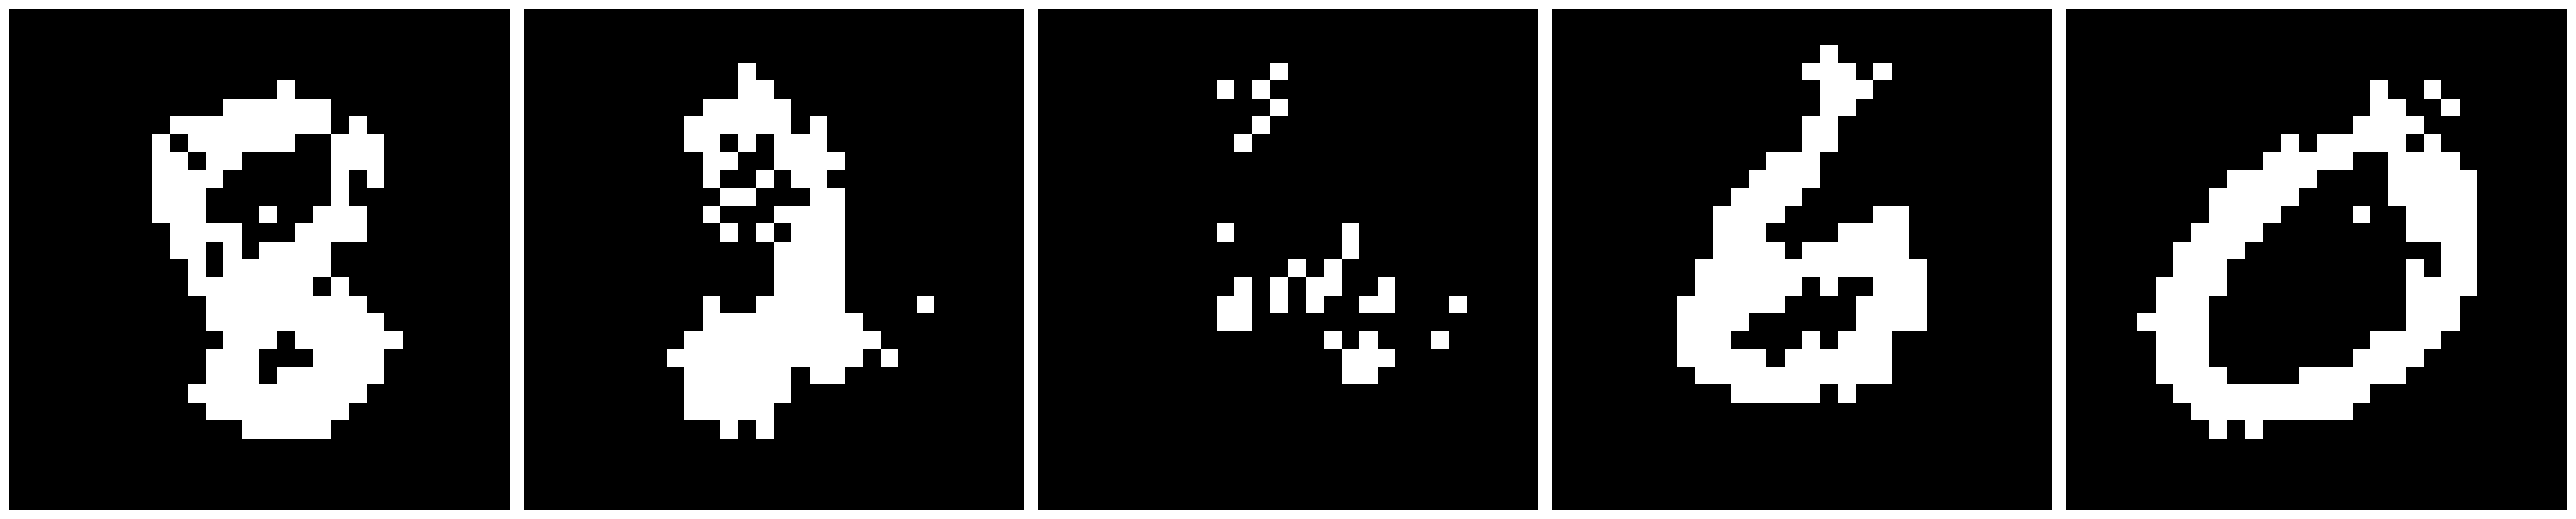

Epoch:   7/ 12, Batch     1, Loss: 0.1088
Epoch:   7/ 12, Batch   101, Loss: 0.1041
Epoch:   7/ 12, Batch   201, Loss: 0.1042
Epoch:   7/ 12, Batch   301, Loss: 0.1047
Epoch:   7/ 12, Batch   401, Loss: 0.1048
Epoch:   7/ 12, Batch   501, Loss: 0.1046
Epoch:   7/ 12, Batch   601, Loss: 0.1052
Epoch:   7/ 12, Batch   701, Loss: 0.1047
Epoch:   7/ 12, Batch   801, Loss: 0.1047
Epoch:   7/ 12, Batch   901, Loss: 0.1045
-----------------------------------------
Epoch:   7 took 4.02s
Epoch:   7, Test Loss: 0.1082
-----------------------------------------


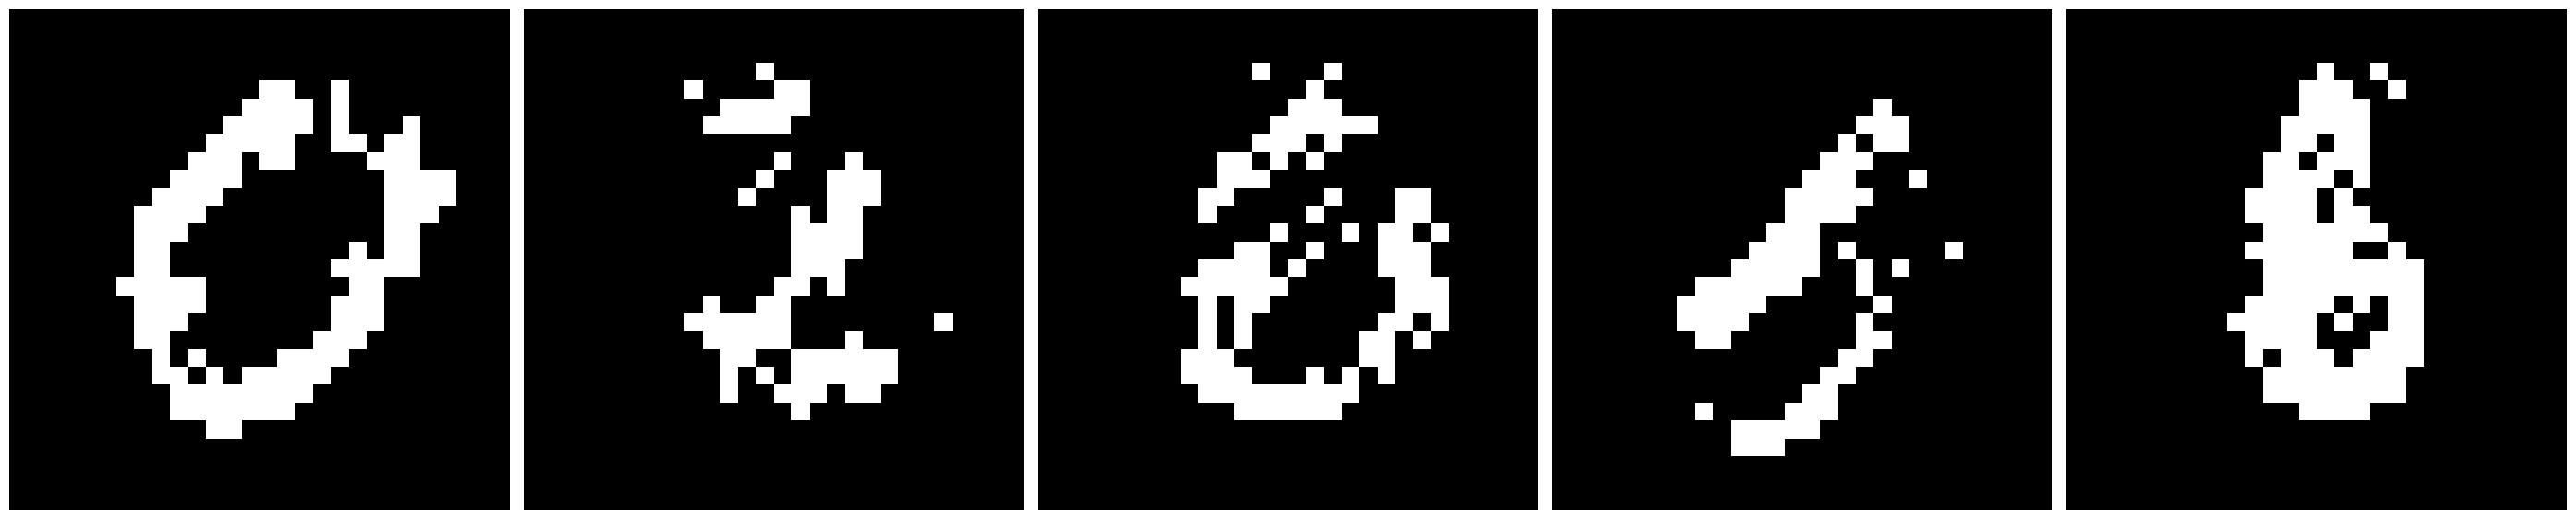

Epoch:   8/ 12, Batch     1, Loss: 0.1018
Epoch:   8/ 12, Batch   101, Loss: 0.1016
Epoch:   8/ 12, Batch   201, Loss: 0.1023
Epoch:   8/ 12, Batch   301, Loss: 0.1017
Epoch:   8/ 12, Batch   401, Loss: 0.1026
Epoch:   8/ 12, Batch   501, Loss: 0.1027
Epoch:   8/ 12, Batch   601, Loss: 0.1029
Epoch:   8/ 12, Batch   701, Loss: 0.1029
Epoch:   8/ 12, Batch   801, Loss: 0.1019
Epoch:   8/ 12, Batch   901, Loss: 0.1025
-----------------------------------------
Epoch:   8 took 4.49s
Epoch:   8, Test Loss: 0.1073
-----------------------------------------


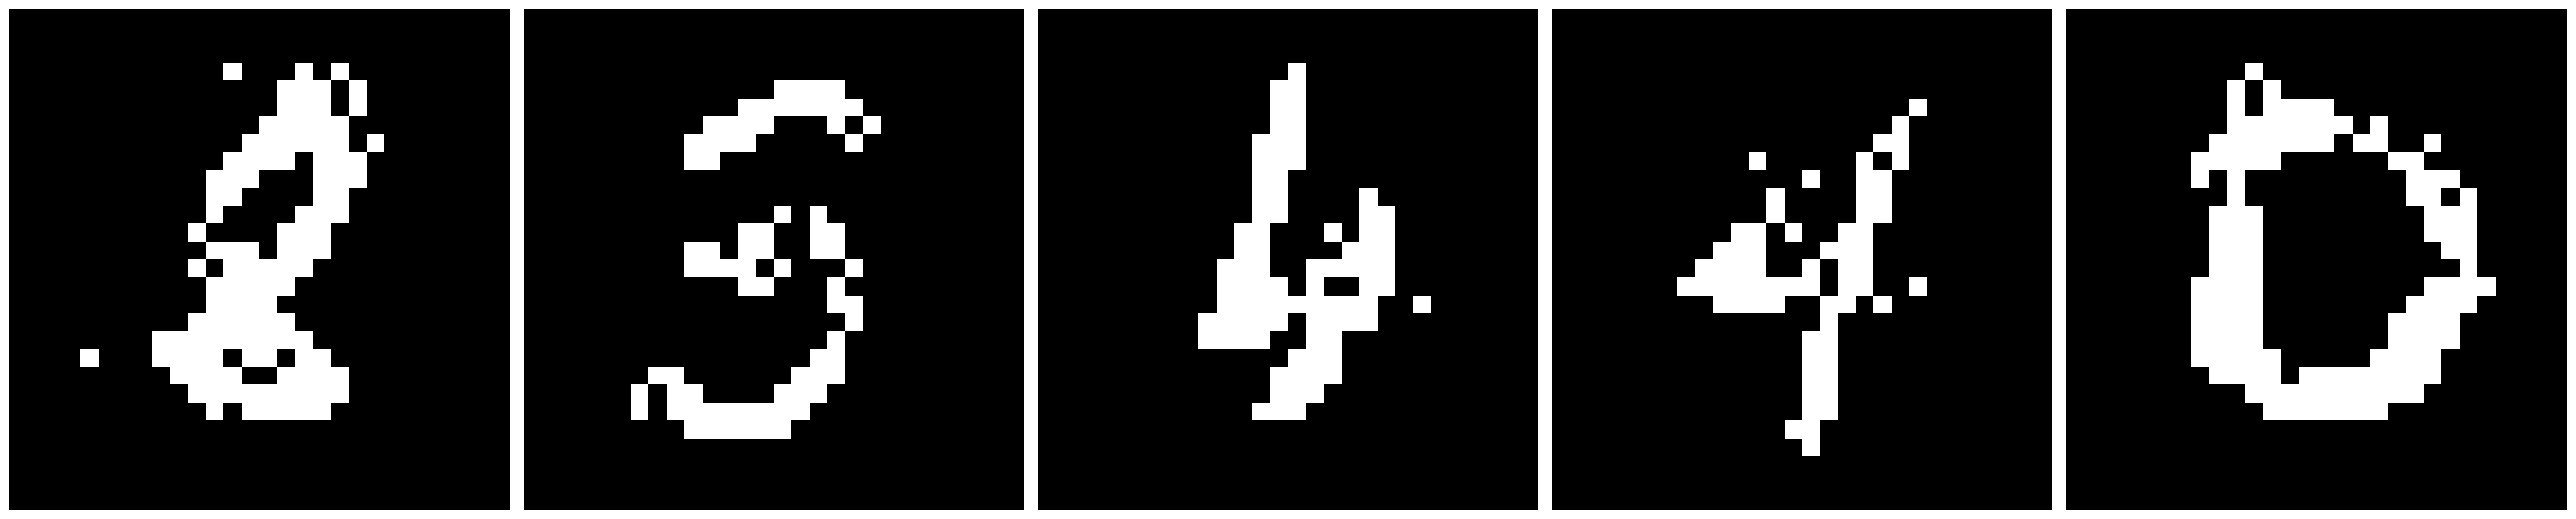

Epoch:   9/ 12, Batch     1, Loss: 0.0999
Epoch:   9/ 12, Batch   101, Loss: 0.0987
Epoch:   9/ 12, Batch   201, Loss: 0.0994
Epoch:   9/ 12, Batch   301, Loss: 0.1000
Epoch:   9/ 12, Batch   401, Loss: 0.0991
Epoch:   9/ 12, Batch   501, Loss: 0.1007
Epoch:   9/ 12, Batch   601, Loss: 0.0999
Epoch:   9/ 12, Batch   701, Loss: 0.1005
Epoch:   9/ 12, Batch   801, Loss: 0.1009
Epoch:   9/ 12, Batch   901, Loss: 0.1005
-----------------------------------------
Epoch:   9 took 4.42s
Epoch:   9, Test Loss: 0.1061
-----------------------------------------


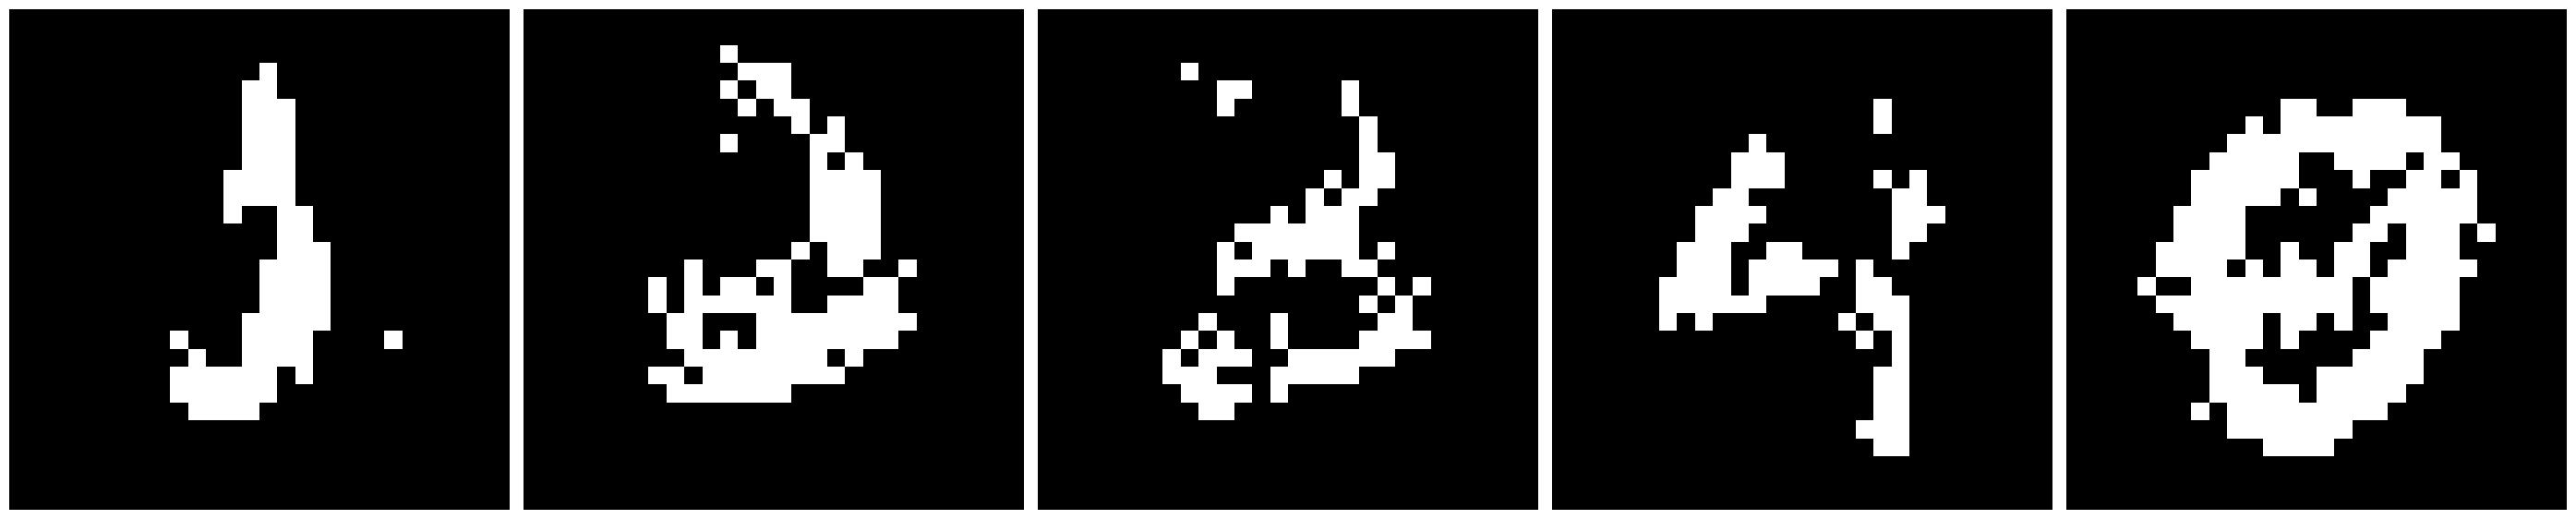

Epoch:  10/ 12, Batch     1, Loss: 0.0977
Epoch:  10/ 12, Batch   101, Loss: 0.0970
Epoch:  10/ 12, Batch   201, Loss: 0.0981
Epoch:  10/ 12, Batch   301, Loss: 0.0980
Epoch:  10/ 12, Batch   401, Loss: 0.0983
Epoch:  10/ 12, Batch   501, Loss: 0.0990
Epoch:  10/ 12, Batch   601, Loss: 0.0985
Epoch:  10/ 12, Batch   701, Loss: 0.0990
Epoch:  10/ 12, Batch   801, Loss: 0.0993
Epoch:  10/ 12, Batch   901, Loss: 0.0983
-----------------------------------------
Epoch:  10 took 4.51s
Epoch:  10, Test Loss: 0.1058
-----------------------------------------


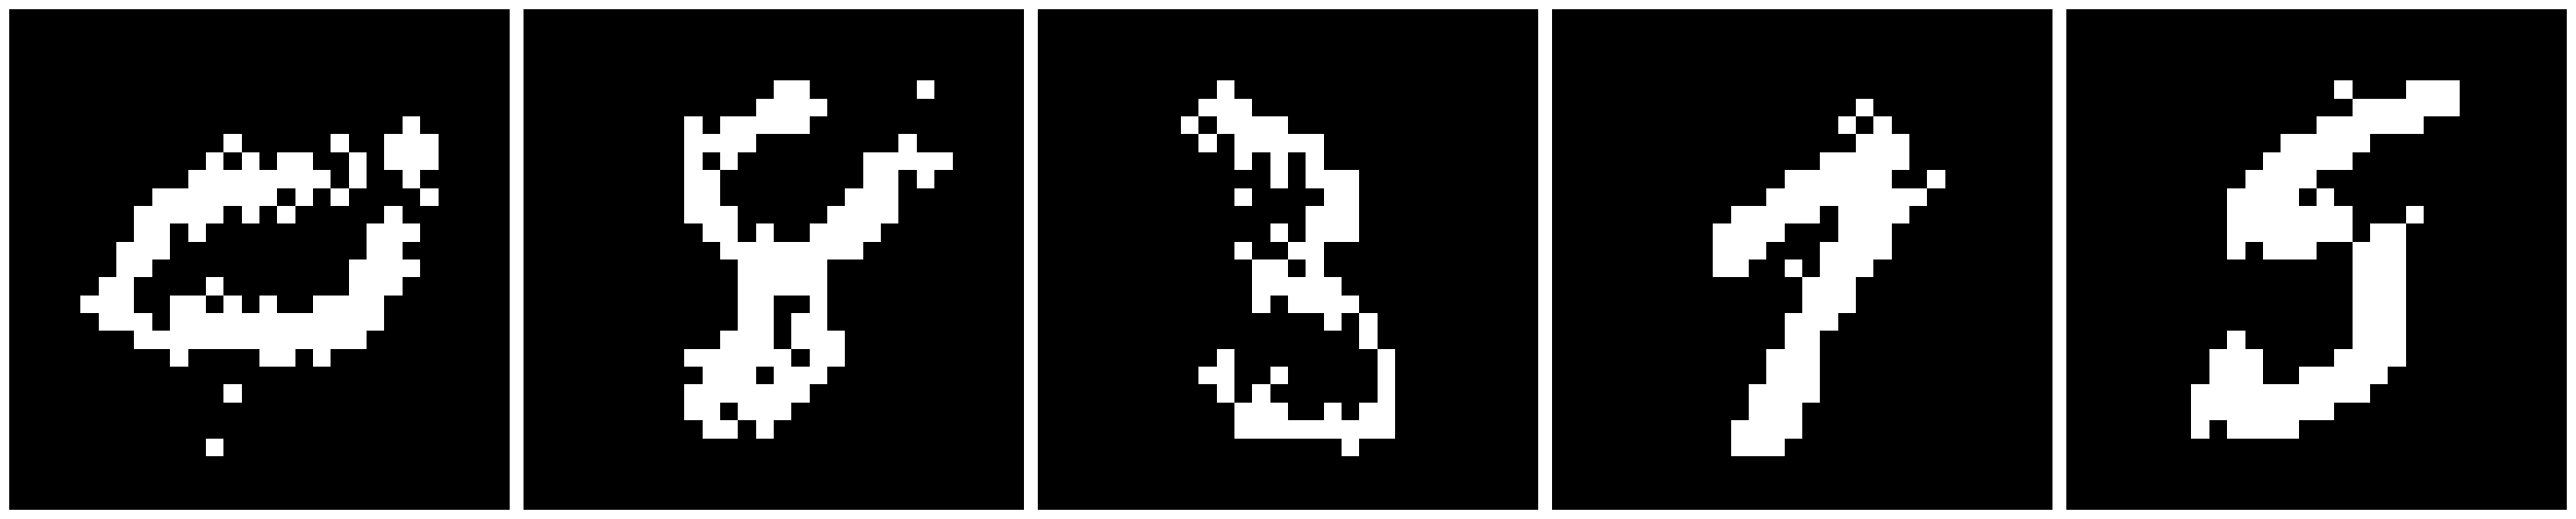

Epoch:  11/ 12, Batch     1, Loss: 0.0973
Epoch:  11/ 12, Batch   101, Loss: 0.0960
Epoch:  11/ 12, Batch   201, Loss: 0.0952
Epoch:  11/ 12, Batch   301, Loss: 0.0956
Epoch:  11/ 12, Batch   401, Loss: 0.0969
Epoch:  11/ 12, Batch   501, Loss: 0.0969
Epoch:  11/ 12, Batch   601, Loss: 0.0968
Epoch:  11/ 12, Batch   701, Loss: 0.0972
Epoch:  11/ 12, Batch   801, Loss: 0.0970
Epoch:  11/ 12, Batch   901, Loss: 0.0973
-----------------------------------------
Epoch:  11 took 4.42s
Epoch:  11, Test Loss: 0.1051
-----------------------------------------


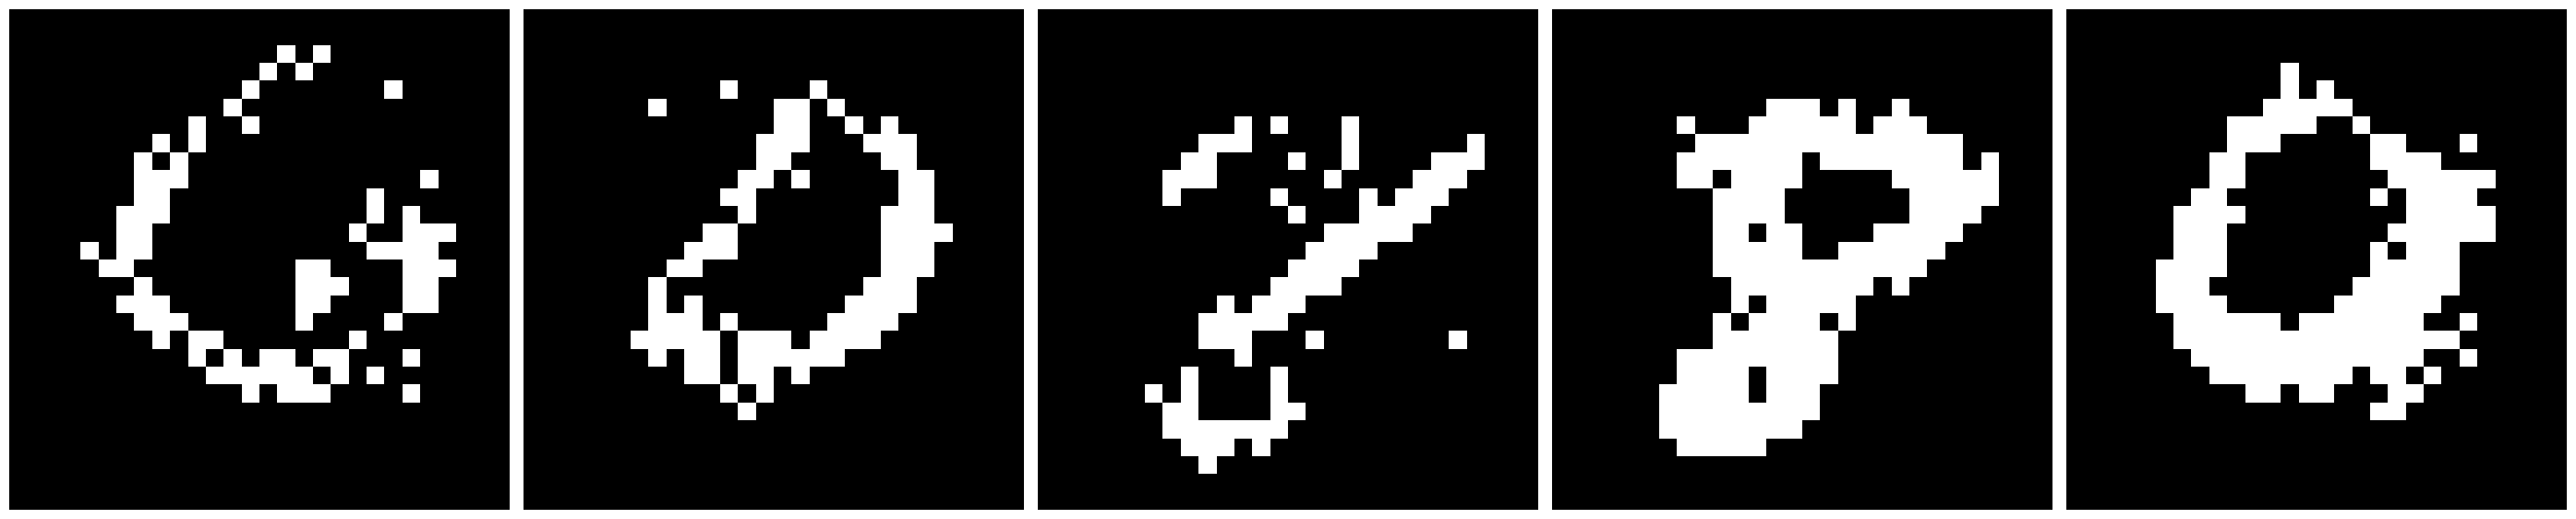

Epoch:  12/ 12, Batch     1, Loss: 0.0980
Epoch:  12/ 12, Batch   101, Loss: 0.0950
Epoch:  12/ 12, Batch   201, Loss: 0.0951
Epoch:  12/ 12, Batch   301, Loss: 0.0955
Epoch:  12/ 12, Batch   401, Loss: 0.0948
Epoch:  12/ 12, Batch   501, Loss: 0.0953
Epoch:  12/ 12, Batch   601, Loss: 0.0955
Epoch:  12/ 12, Batch   701, Loss: 0.0955
Epoch:  12/ 12, Batch   801, Loss: 0.0952
Epoch:  12/ 12, Batch   901, Loss: 0.0957
-----------------------------------------
Epoch:  12 took 4.45s
Epoch:  12, Test Loss: 0.1050
-----------------------------------------


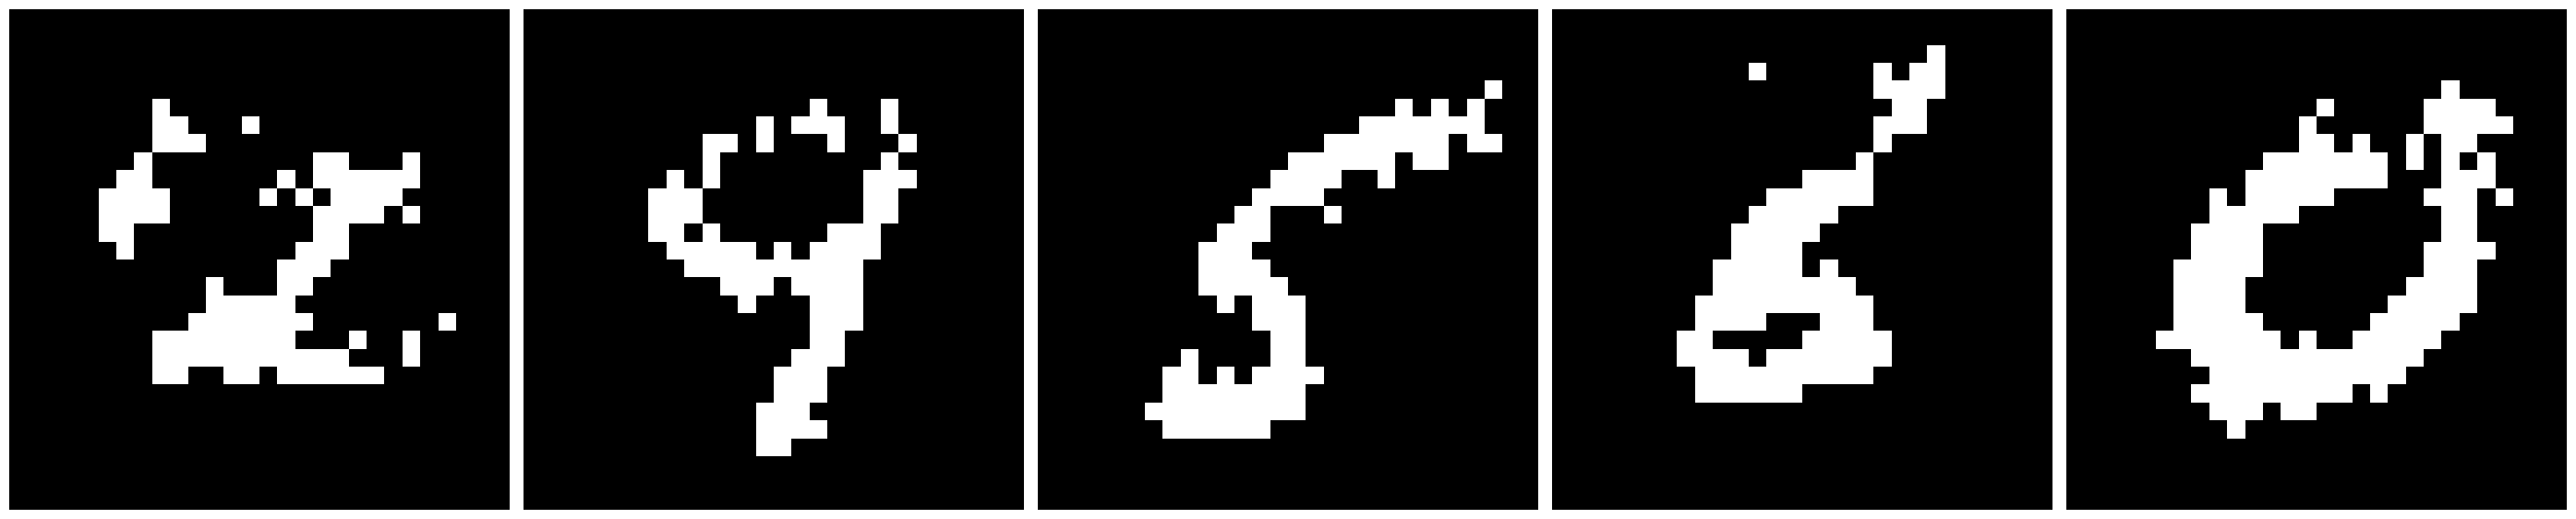

Training took 66.13s


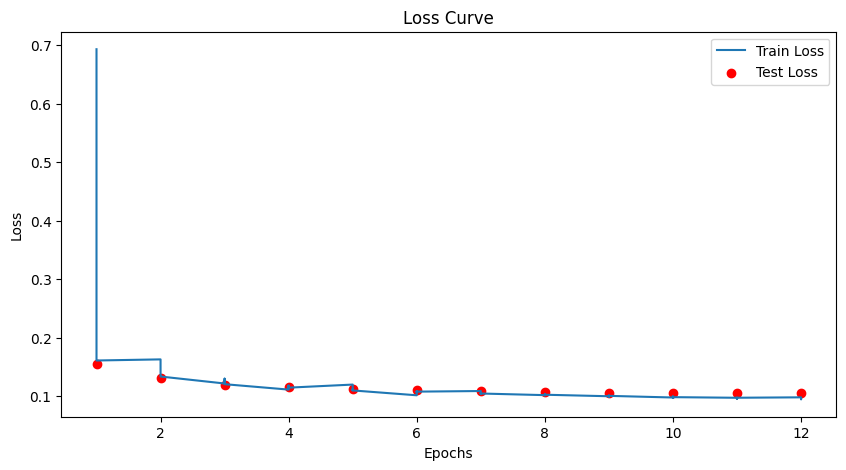

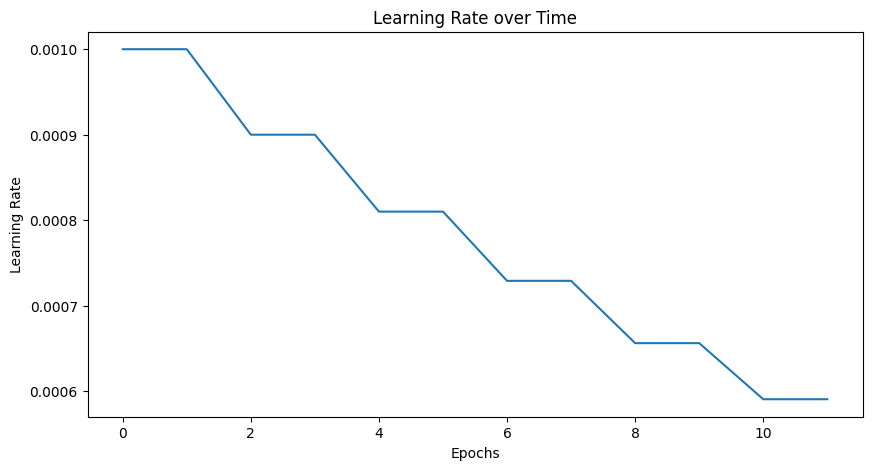

In [8]:
# Training
import time
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
from torch.optim import Adam, AdamW, RMSprop, SGD 

MADE = networks.MADE(num_layer=num_layer, num_units=num_units, ordering=ordering, input_feat=28*28)

# Select device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(f'Using device: {device}')
print('=========================================')

MADE.to(device)

learning_rates = []
train_loss_curve = []
test_loss_curve = []
train_loss_epochs = []
test_loss_epochs = []
optimizer = None

# Select optimizer
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(MADE.parameters(), lr)
  
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(MADE.parameters(), lr)
  
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(MADE.parameters(), lr)
  
else:
  optimizer = torch.optim.SGD(MADE.parameters(), lr, momentum=0.9)  


#Select scheduler
scheduler = None
if lr_scheduler_option == 'step':
    scheduler = StepLR(optimizer, step_size=2, gamma=0.9)
    
elif lr_scheduler_option == 'exponential':
    scheduler = ExponentialLR(optimizer, gamma=0.9)
    
elif lr_scheduler_option == 'cosine':
    scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

overall_start_time = time.time()

# training loop
for epoch in range(num_epochs):

  epoch_start_time = time.time()
  # Switch to training mode.
  MADE.train()

  losses = []
  batch_idx = 0

  for images, labels in training_data:

    images = images.to(device)

    output = MADE(images)
    loss = nn.functional.binary_cross_entropy(output, images)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(MADE.parameters(), 1)
    optimizer.step()
    for param_group in optimizer.param_groups:
      learning_rates.append(param_group['lr'])
    optimizer.zero_grad(set_to_none=True)


    losses.append(loss.detach().clone())

    if batch_idx % 100 == 0:
      average_loss = torch.stack(losses).mean().item()
      train_loss_curve.append(average_loss)
      train_loss_epochs.append(epoch + 1)
      losses = []
      print(f'Epoch: {epoch + 1:3d}/{num_epochs:3d}, Batch {batch_idx + 1:5d}, Loss: {average_loss:.4f}')
    batch_idx += 1

  scheduler.step()
  epoch_end_time = time.time()
  print('-----------------------------------------')
  print(f'Epoch: {epoch + 1:3d} took {epoch_end_time - epoch_start_time:.2f}s')
  test_loss = evaluation.evaluate(model=MADE, test_data_loader=test_data, device=device)
  test_loss_curve.append(test_loss)
  test_loss_epochs.append(epoch + 1)
  print(f'Epoch: {epoch + 1:3d}, Test Loss: {test_loss:.4f}')
  print('-----------------------------------------')
  

  samples = sampling.sample(MADE, num_samples=5)
  sampling.save_samples(samples)

  

overall_end_time = time.time()
print('=========================================')
print(f'Training took {overall_end_time - overall_start_time:.2f}s')

# Loss Curve Plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss_epochs, train_loss_curve, label='Train Loss')
plt.scatter(test_loss_epochs, test_loss_curve, color='red', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Learning Rate Plot
num_batches = len(training_data)
learning_rates_res = [sum(learning_rates[i * num_batches:(i + 1) * num_batches]) / num_batches for i in range(num_epochs)]
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), learning_rates_res)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Time')
plt.show()

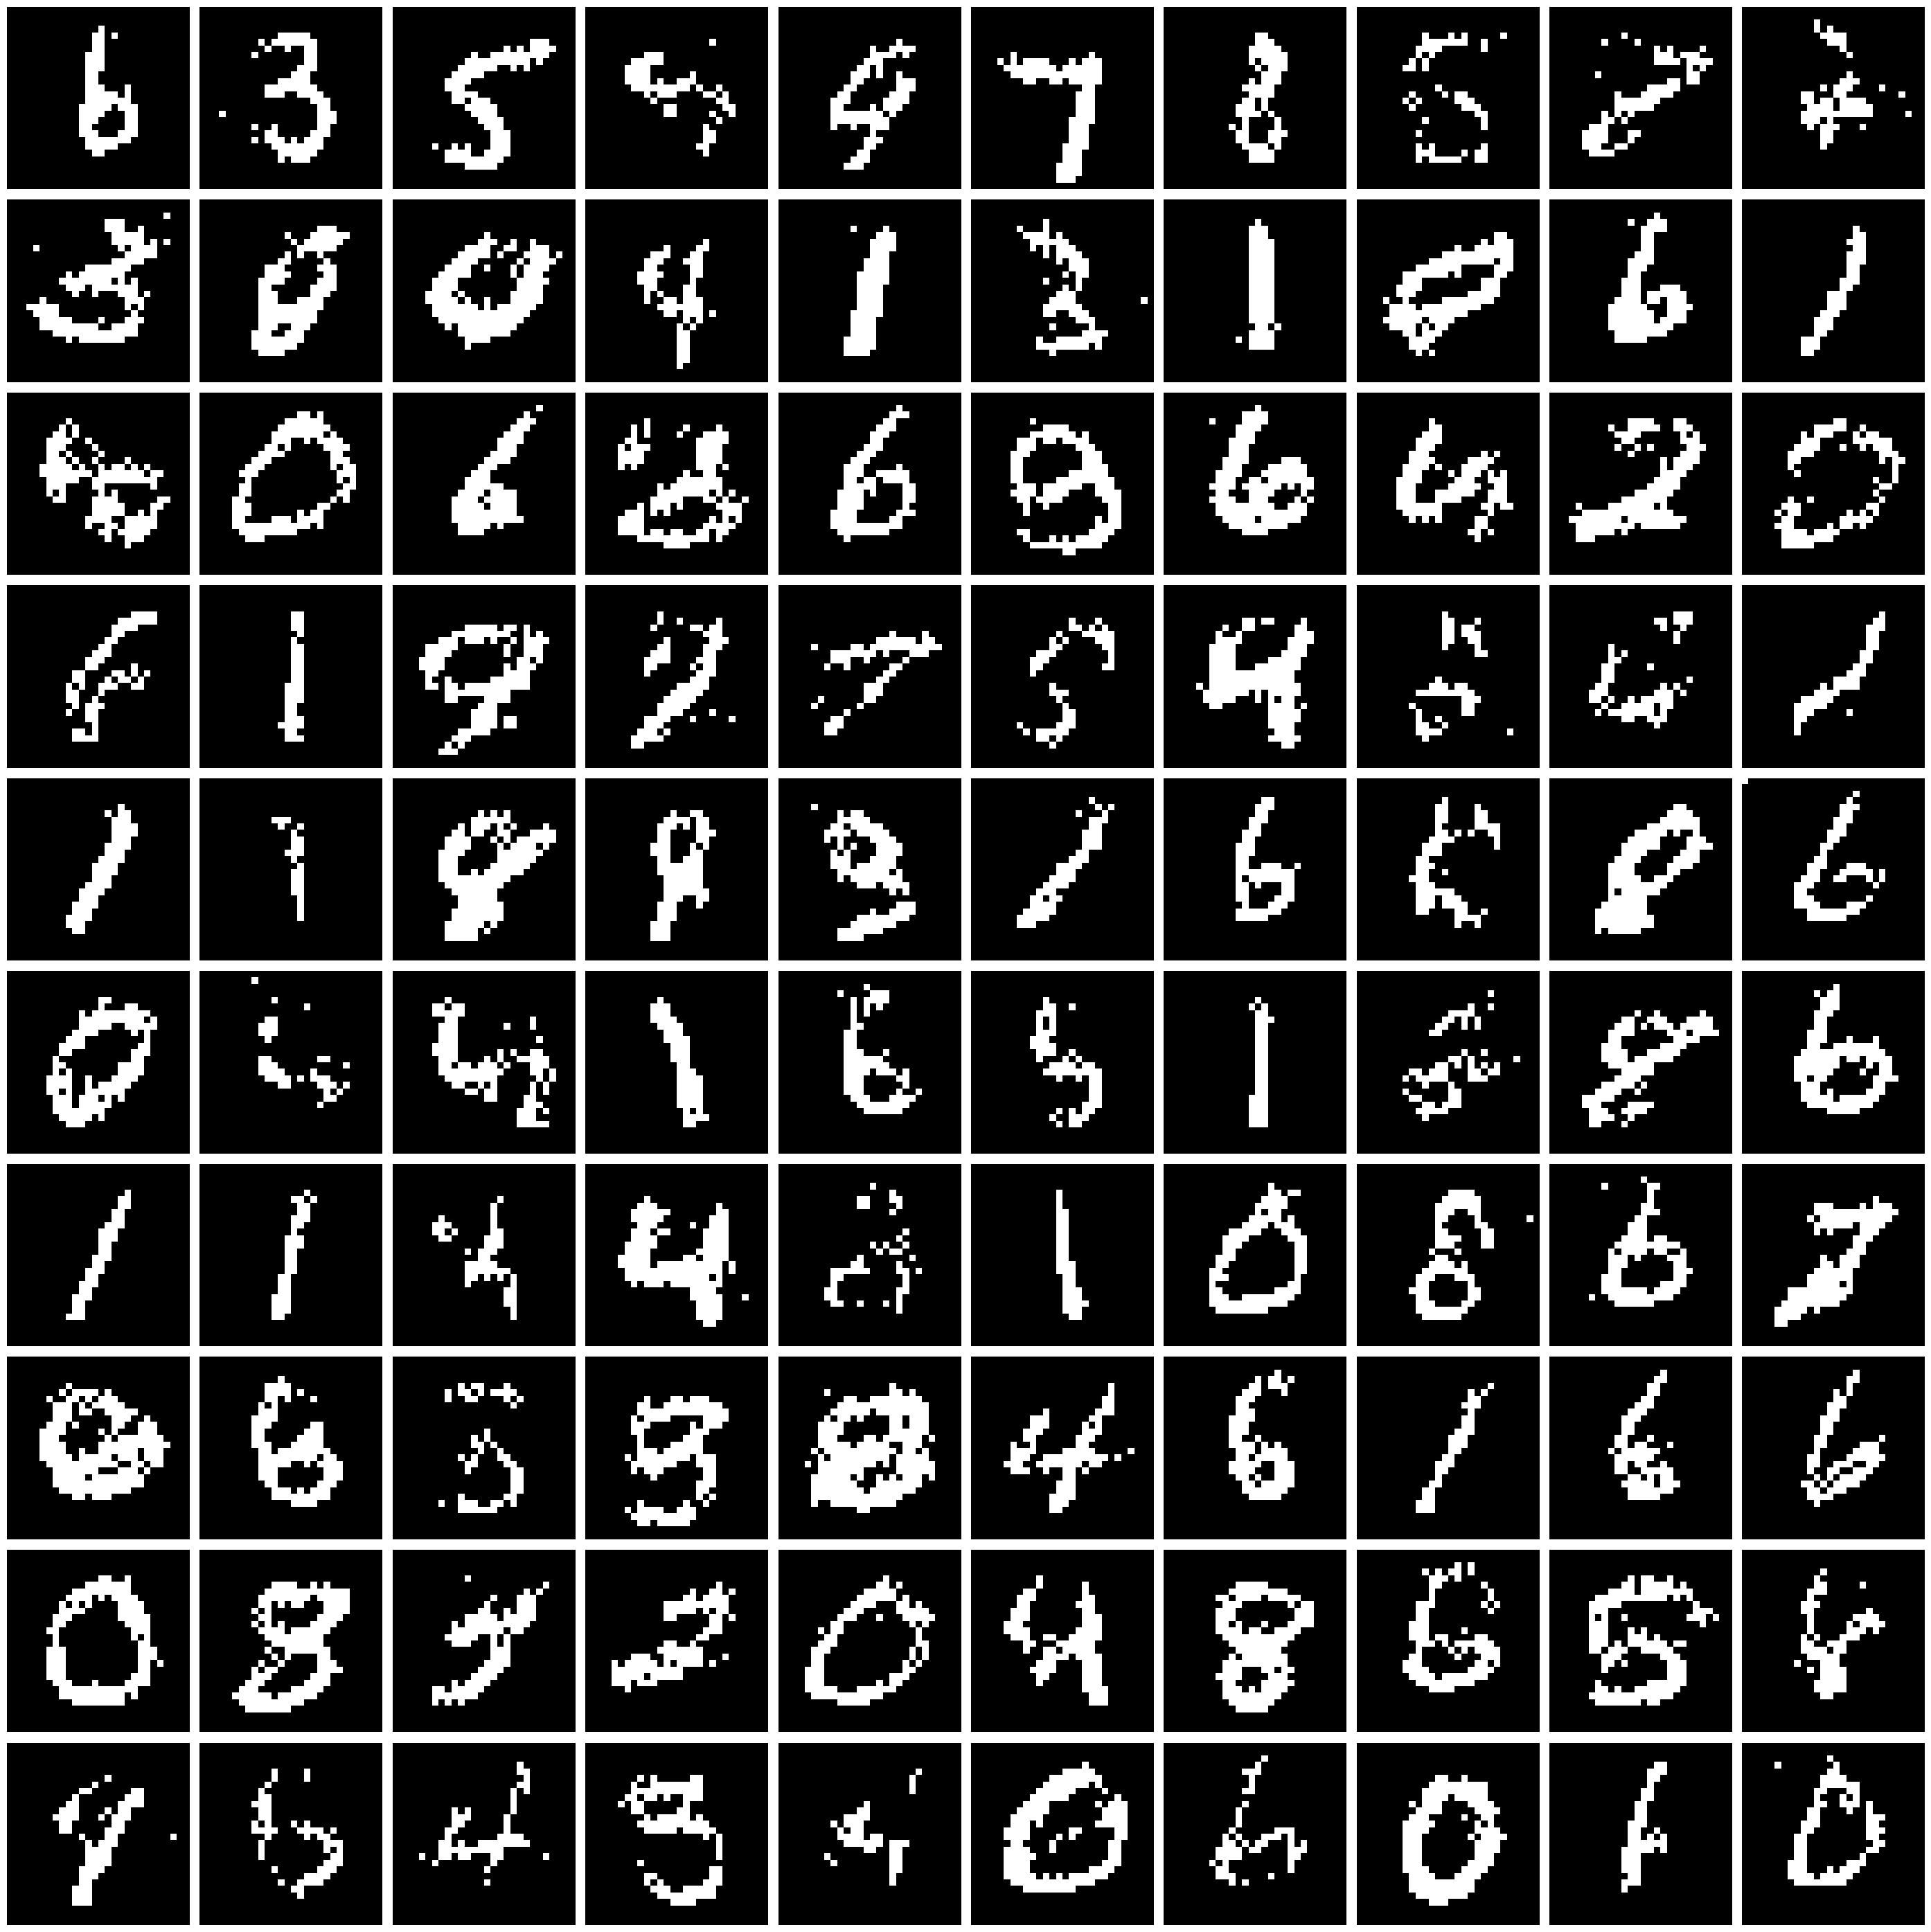

In [9]:
final_samples= sampling.sample(MADE, num_samples=100)
sampling.save_samples(final_samples)